In [53]:
import pandas as pd
import pandas_profiling as pp
import numpy as np
import sklearn
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize
from scipy.cluster.hierarchy import dendrogram
import scipy.cluster.hierarchy as shc
from itertools import combinations

In [54]:
def define_pandas_options():
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [77]:
pl_cols = ['gameId', 'playId', 'offense_h_play', 'offense_h_presnap', 'offense_h_to_throw', 'offense_h_to_arrived', 'offense_h_to_end', 'defense_h_play', 'defense_h_presnap', 'defense_h_to_throw', 'defense_h_to_arrived', 'defense_h_to_end', 'offense_p_play', 'offense_p_presnap', 'offense_p_to_throw', 'offense_p_to_arrived', 'offense_p_to_end', 'offense_m_play', 'offense_m_presnap', 'offense_m_to_throw', 'offense_m_to_arrived', 'offense_m_to_end', 'offense_v_play', 'offense_v_presnap', 'offense_v_to_throw', 'offense_v_to_arrived', 'offense_v_to_end', 'offense_a_play', 'offense_a_presnap', 'offense_a_to_throw', 'offense_a_to_arrived','offense_a_to_end', 'defense_p_play', 'defense_p_presnap','defense_p_to_throw', 'defense_p_to_arrived', 'defense_p_to_end','defense_m_play', 'defense_m_presnap', 'defense_m_to_throw','defense_m_to_arrived', 'defense_m_to_end', 'defense_v_play', 'defense_v_presnap', 'defense_v_to_throw', 'defense_v_to_arrived','defense_v_to_end', 'defense_a_play', 'defense_a_presnap','defense_a_to_throw', 'defense_a_to_arrived', 'defense_a_to_end','HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER', 'IN', 'ANGLE', 'POST', 'WHEEL', 'num_routes']
play_df = pd.read_csv('d20_intermediate_files/play_results.csv', usecols=pl_cols)
play_df.drop(play_df[play_df['num_routes'] == 0].index, inplace=True)
play_df.dropna(inplace=True)

fr_cols = ['gameId', 'playId', 'frameId', 'offense_p_group', 'defense_p_group', 'offense_m_group', 'defense_m_group', 'o_state', 'd_state', 'offense_v_group', 'defense_v_group', 'offense_a_group', 'defense_a_group', 'a_group_ratio']
frame_df = pd.read_csv('d20_intermediate_files/frame_results.csv', usecols=fr_cols)

tr_cols = ['time', 's', 'a', 'dis', 'event', 'nflId', 'displayName', 'jerseyNumber', 'position', 'frameId', 'team', 'gameId', 'playId', 'playDirection', 'route', 'pos', 'teamType', 'o_vec', 'dir_vec', 'r_vec']
tracking_df = pd.read_csv('d20_intermediate_files/tracking_results.csv', usecols=tr_cols)

In [78]:
play_df

,gameId,playId,offense_h_play,offense_h_presnap,offense_h_to_throw,offense_h_to_arrived,offense_h_to_end,defense_h_play,defense_h_presnap,defense_h_to_throw,...,CROSS,GO,SLANT,SCREEN,CORNER,IN,ANGLE,POST,WHEEL,num_routes
0,2018091602,51,4.563989,-0.000000,4.318318,4.425326,3.596252,4.301343,0.237508,3.887902,...,0,1,0,0,0,1,0,0,0,5
1,2018091602,75,4.739197,0.329846,4.211677,3.829987,4.649391,5.660144,2.066397,4.342403,...,0,1,0,1,0,0,1,0,0,3
2,2018091602,141,5.244124,-0.000000,5.631546,4.078897,3.637780,5.242657,1.214913,5.182584,...,1,0,0,0,0,1,0,0,0,5
4,2018091602,199,5.311352,1.081988,4.670134,3.324092,5.122701,5.035327,2.011104,3.369678,...,0,1,1,1,0,1,0,1,0,5
5,2018091602,242,5.432691,-0.000000,5.818093,3.419382,4.343448,5.841834,1.557855,5.692065,...,2,0,0,0,1,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2018092304,3330,5.629911,0.113274,5.564091,4.195752,4.782337,5.337208,0.890305,4.835691,...,1,0,1,0,1,0,0,0,0,4
238,2018092304,3567,5.555004,-0.000000,4.712670,3.531645,5.311345,5.426882,0.520335,4.006425,...,0,0,2,1,0,0,0,0,0,5
239,2018092304,3803,5.154549,0.266765,4.169312,3.695190,4.942504,5.624974,1.907458,3.969413,...,1,2,0,0,0,0,0,0,0,5
240,2018092304,3832,4.762376,-0.000000,5.029039,3.698998,3.578697,5.279938,2.125105,5.063748,...,2,0,0,0,0,0,0,1,0,5


In [79]:
def string_to_vector(s):
    try:
        s = s.split('[')[1].split(']')[0]
        x = float(s.split()[0])
        y = float(s.split()[1])
        return np.array([x, y])
    except AttributeError:
        return None

def get_position_delta(row):
    return row.s / 10 * row.dir_vec

def get_relative_position(row):
    if row.frameId == 1:
        return np.array([0, 0])
    else:
        last_pos = row.shift(1).rel_pos
        return last_pos + row.pos_delta

In [80]:
tracking_df['pos'] = tracking_df['pos'].apply(string_to_vector)
tracking_df['o_vec'] = tracking_df['o_vec'].apply(string_to_vector)
tracking_df['dir_vec'] = tracking_df['dir_vec'].apply(string_to_vector)
tracking_df['r_vec'] = tracking_df['r_vec'].apply(string_to_vector)

In [81]:
# Attempt clustering of play data

In [294]:
df = play_df[['gameId', 'playId', 'offense_h_presnap',
       'offense_h_to_throw', 'offense_h_to_arrived',
       'offense_p_presnap', 'offense_p_to_throw', 'offense_p_to_arrived',
       'offense_m_presnap',
       'offense_m_to_throw', 'offense_m_to_arrived', 'offense_v_presnap', 'offense_v_to_throw',
       'offense_v_to_arrived',
       'offense_a_presnap', 'offense_a_to_throw', 'offense_a_to_arrived',
       'HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER',
       'IN', 'ANGLE', 'POST', 'WHEEL', 'num_routes']].dropna().copy()

df_scaled = normalize(df)
df_scaled = pd.DataFrame(df_scaled, columns=df.columns).drop(['gameId', 'playId'], axis=1)

In [85]:
km = KMeans(
    n_clusters=8, init='random',
    n_init=3, max_iter=300,
    tol=1e-04, random_state=0
)

y_km = km.fit_predict(df_scaled)

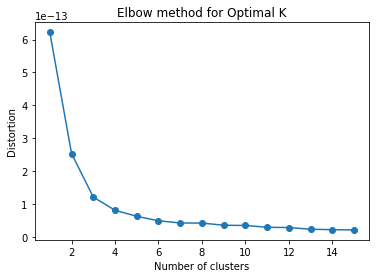

In [87]:
distortions = []
num_plays = 15

for i in range(1, num_plays + 1):
     km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
     km.fit(df_scaled)
     distortions.append(km.inertia_)

plt.plot(range(1, num_plays + 1), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('Elbow method for Optimal K')
plt.show()

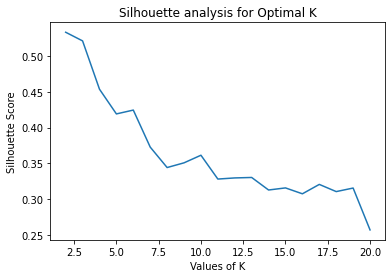

In [156]:
range_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
silhouette_avg = []
for i in range_clusters:
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(df_scaled)
    cluster_labels = km.labels_

    silhouette_avg.append(silhouette_score(df_scaled, cluster_labels))

plt.plot(range_clusters, silhouette_avg)
plt.xlabel('Values of K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette analysis for Optimal K')
plt.show()

In [166]:
limit = 0.0000001
model = AgglomerativeClustering(linkage='ward',
                                affinity='euclidean',
                                distance_threshold=limit,
                                n_clusters=None)
model.fit(df_scaled)
df['cluster'] = model.labels_

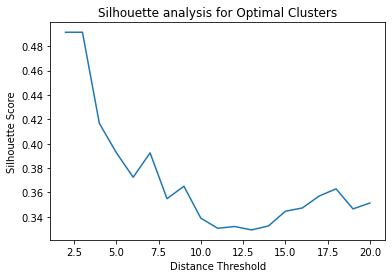

In [228]:
range_clusters = []
n_samples = df_scaled.shape[0]
[range_clusters.append(x) for x in range(2, 21)]
silhouette_avg = []

for i in range_clusters:
    model = AgglomerativeClustering(linkage='ward',
                                affinity='euclidean',
                                distance_threshold=None,
                                n_clusters=i)
    model.fit(df_scaled)
    cluster_labels = model.labels_
    silhouette_avg.append(silhouette_score(df_scaled, cluster_labels))

fig, ax = plt.subplots()
ax.plot(range_clusters, silhouette_avg)
ax.set_xlabel('Distance Threshold')
ax.set_ylabel('Silhouette Score')
ax.set_title('Silhouette analysis for Optimal Clusters')
plt.show()

In [303]:
model = AgglomerativeClustering(linkage='ward',
                                affinity='euclidean',
                                distance_threshold=None,
                                n_clusters=2)
model.fit(df_scaled)

AgglomerativeClustering()

In [304]:
df_scaled['cluster'] = model.labels_
print(df_scaled['cluster'].value_counts())

0    86
1    37
Name: cluster, dtype: int64


In [305]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=0)
clf.fit(df_scaled[['offense_h_presnap', 'offense_h_to_throw', 'offense_h_to_arrived',
       'offense_p_presnap', 'offense_p_to_throw', 'offense_p_to_arrived',
       'offense_m_presnap', 'offense_m_to_throw', 'offense_m_to_arrived',
       'offense_v_presnap', 'offense_v_to_throw', 'offense_v_to_arrived',
       'offense_a_presnap', 'offense_a_to_throw', 'offense_a_to_arrived',
       'HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER',
       'IN', 'ANGLE', 'POST', 'WHEEL']], df_scaled['cluster'])

RandomForestClassifier(random_state=0)

In [306]:
clf.score(df_scaled[['offense_h_presnap', 'offense_h_to_throw', 'offense_h_to_arrived',
       'offense_p_presnap', 'offense_p_to_throw', 'offense_p_to_arrived',
       'offense_m_presnap', 'offense_m_to_throw', 'offense_m_to_arrived',
       'offense_v_presnap', 'offense_v_to_throw', 'offense_v_to_arrived',
       'offense_a_presnap', 'offense_a_to_throw', 'offense_a_to_arrived',
       'HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER',
       'IN', 'ANGLE', 'POST', 'WHEEL']], df_scaled['cluster'])

0.6991869918699187

In [ ]:
sorted_feature_weight_indexes = np.argsort(clf.feature_importances_)[::-1]

most_imp_features = np.take_along_axis(
    np.array(df_scaled.iloc[:, 1:28].columns.tolist()),
    sorted_feature_weight_indexes, axis=0)
most_imp_weights = np.take_along_axis(
    np.array(clf.feature_importances_),
    sorted_feature_weight_indexes, axis=0)

list(zip(most_imp_features, most_imp_weights))

In [264]:
clf.feature_importances_

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [262]:
df_scaled[['offense_h_presnap', 'offense_h_to_throw', 'offense_h_to_arrived',
       'offense_p_presnap', 'offense_p_to_throw', 'offense_p_to_arrived',
       'offense_m_presnap', 'offense_m_to_throw', 'offense_m_to_arrived',
       'offense_v_presnap', 'offense_v_to_throw', 'offense_v_to_arrived',
       'offense_a_presnap', 'offense_a_to_throw', 'offense_a_to_arrived',
       'HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER',
       'IN', 'ANGLE', 'POST', 'WHEEL']]

,offense_h_presnap,offense_h_to_throw,offense_h_to_arrived,offense_p_presnap,offense_p_to_throw,offense_p_to_arrived,offense_m_presnap,offense_m_to_throw,offense_m_to_arrived,offense_v_presnap,...,FLAT,CROSS,GO,SLANT,SCREEN,CORNER,IN,ANGLE,POST,WHEEL
0,-0.000000e+00,2.139803e-09,2.192827e-09,1.188526e-10,3.024231e-10,2.196935e-10,6.097653e-11,1.425837e-10,1.988548e-10,4.613993e-12,...,4.955176e-10,0.000000e+00,4.955176e-10,0.000000e+00,0.000000e+00,0.000000e+00,4.955176e-10,0.000000e+00,0.000000e+00,0.0
1,1.634445e-10,2.086960e-09,1.897826e-09,2.350800e-10,1.363060e-10,2.157313e-10,1.649357e-10,1.516809e-10,1.079273e-10,1.171512e-11,...,0.000000e+00,0.000000e+00,4.955176e-10,0.000000e+00,4.955176e-10,0.000000e+00,0.000000e+00,4.955176e-10,0.000000e+00,0.0
2,-0.000000e+00,2.790530e-09,2.021165e-09,2.962438e-10,2.755622e-10,2.158115e-10,9.072329e-11,8.866837e-11,1.839219e-10,5.071832e-12,...,0.000000e+00,4.955176e-10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.955176e-10,0.000000e+00,0.000000e+00,0.0
3,5.361441e-10,2.314134e-09,1.647146e-09,2.101253e-10,2.666717e-10,1.376139e-10,1.644267e-10,1.495394e-10,2.162581e-10,2.640190e-11,...,0.000000e+00,0.000000e+00,4.955176e-10,4.955176e-10,4.955176e-10,0.000000e+00,4.955176e-10,0.000000e+00,4.955176e-10,0.0
4,-0.000000e+00,2.882968e-09,1.694364e-09,2.362618e-10,2.328780e-10,2.730207e-10,1.480589e-10,2.238643e-10,1.341884e-10,5.526019e-12,...,9.910353e-10,9.910353e-10,0.000000e+00,0.000000e+00,0.000000e+00,4.955176e-10,0.000000e+00,0.000000e+00,0.000000e+00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,5.612940e-11,2.757104e-09,2.079069e-09,8.927506e-11,1.571982e-10,3.448700e-10,1.563989e-10,1.730857e-10,1.545535e-10,7.445588e-12,...,4.955175e-10,4.955175e-10,0.000000e+00,4.955175e-10,0.000000e+00,4.955175e-10,0.000000e+00,0.000000e+00,0.000000e+00,0.0
119,-0.000000e+00,2.335210e-09,1.749992e-09,2.373395e-10,3.353290e-10,3.030397e-10,5.990944e-11,1.131989e-10,1.443958e-10,2.864338e-12,...,9.910349e-10,0.000000e+00,0.000000e+00,9.910349e-10,4.955175e-10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
120,1.321867e-10,2.065967e-09,1.831031e-09,9.135558e-11,2.896089e-10,3.909149e-10,9.217725e-11,1.333376e-10,7.787041e-11,8.554056e-12,...,4.955175e-10,4.955175e-10,9.910349e-10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
121,-0.000000e+00,2.491977e-09,1.832918e-09,1.733760e-10,3.433332e-10,4.545964e-10,9.949883e-11,1.232832e-10,1.030213e-10,9.142345e-12,...,4.955175e-10,9.910349e-10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.955175e-10,0.0


In [216]:
range_limit = []
[range_limit.append(n) for n in np.linspace(5*10**-7, 5*10**-8, 10)]
print(range_limit)
silhouette_avg = []
n_clusters = []
for i in range_limit:
    model = AgglomerativeClustering(linkage='ward',
                                affinity='euclidean',
                                distance_threshold=i,
                                n_clusters=None)
    model.fit(df_scaled)
    cluster_labels = model.labels_
    n_clusters.append(len(np.unique(model.labels_)))

    silhouette_avg.append(silhouette_score(df_scaled, cluster_labels))

fig, ax = plt.subplots()
ax.plot(range_limit, silhouette_avg)
ax.set_xlabel('Distance Threshold')
ax.set_ylabel('Silhouette Score')
ax.set_title('Silhouette analysis for Optimal Clusters')
ax2 = ax.twinx()
ax2.plot(range_limit, n_clusters, color='r')
ax2.set_ylabel('Number of clusters')
plt.show()

[5e-07, 4.5e-07, 4e-07, 3.5e-07, 3e-07, 2.5e-07, 2e-07, 1.5e-07, 1e-07, 5e-08]


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [167]:
len(np.unique(model.labels_))

8

In [150]:
agglom_sizes = df.groupby('cluster').size()
agglom_sizes

cluster
0     4
1     2
2     3
3     5
4     2
     ..
69    1
70    1
71    1
72    1
73    2
Length: 74, dtype: int64

In [151]:
cluster6 = df.drop(['gameId', 'playId', 'cluster'], axis=1).loc[(df['cluster'] == 6)]
cluster6.mean().apply(lambda x: '%.5f' % x)

offense_h_presnap         0.32672
offense_h_to_throw        5.01410
offense_h_to_arrived      4.21912
offense_p_presnap         0.43686
offense_p_to_throw        0.44648
offense_p_to_arrived      0.48222
offense_m_presnap         0.35593
offense_m_to_throw        0.30515
offense_m_to_arrived      0.39719
offense_v_presnap         0.04954
offense_v_to_throw        0.63288
offense_v_to_arrived      1.06961
offense_a_presnap        45.92950
offense_a_to_throw       86.31813
offense_a_to_arrived    241.81201
HITCH                     0.66667
OUT                       0.66667
FLAT                      0.33333
CROSS                     1.00000
GO                        1.33333
SLANT                     0.00000
SCREEN                    0.00000
CORNER                    0.33333
IN                        0.33333
ANGLE                     0.33333
POST                      0.00000
WHEEL                     0.00000
num_routes                5.00000
dtype: object

In [99]:
df.head()

,gameId,playId,offense_h_presnap,offense_h_to_throw,offense_h_to_arrived,offense_p_presnap,offense_p_to_throw,offense_p_to_arrived,offense_m_presnap,offense_m_to_throw,...,GO,SLANT,SCREEN,CORNER,IN,ANGLE,POST,WHEEL,num_routes,cluster
0,2018091602,51,-0.000000,4.318318,4.425326,0.239856,0.610317,0.443362,0.123056,0.287747,...,1,0,0,0,1,0,0,0,5,0
1,2018091602,75,0.329846,4.211677,3.829987,0.474413,0.275078,0.435366,0.332855,0.306106,...,1,0,1,0,0,1,0,0,3,1
2,2018091602,141,-0.000000,5.631546,4.078897,0.597847,0.556110,0.435527,0.183088,0.178941,...,0,0,0,0,1,0,0,0,5,5
4,2018091602,199,1.081988,4.670134,3.324092,0.424052,0.538168,0.277718,0.331828,0.301784,...,1,1,1,0,1,0,1,0,5,3
5,2018091602,242,-0.000000,5.818093,3.419382,0.476798,0.469969,0.550981,0.298796,0.451779,...,0,0,0,1,0,0,0,0,5,5


In [116]:
df.groupby('cluster')[['HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER',
       'IN', 'ANGLE', 'POST', 'WHEEL']].mean().T

cluster,0,1,2,3,4,5,6,7
HITCH,1.041667,0.928571,1.000000,0.681818,0.666667,0.777778,0.0,0.50
OUT,0.625000,0.357143,0.736842,0.636364,0.500000,0.611111,1.5,1.00
FLAT,0.625000,0.750000,0.368421,0.545455,0.666667,0.611111,0.0,0.50
CROSS,0.458333,0.321429,0.315789,0.318182,0.500000,0.555556,0.0,0.00
GO,0.583333,0.392857,0.842105,0.636364,1.333333,0.777778,1.0,1.50
SLANT,0.041667,0.785714,0.368421,0.909091,0.000000,0.111111,0.0,0.00
SCREEN,0.250000,0.464286,0.263158,0.136364,0.000000,0.111111,0.5,0.00
CORNER,0.166667,0.107143,0.052632,0.227273,0.000000,0.222222,0.5,0.50
IN,0.375000,0.071429,0.210526,0.318182,0.166667,0.555556,0.0,0.00
ANGLE,0.166667,0.285714,0.210526,0.181818,0.000000,0.111111,0.5,0.25


In [121]:
df.groupby(['gameId'])[['HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER',
       'IN', 'ANGLE', 'POST', 'WHEEL']].mean().T

gameId,2018091602,2018091605,2018092304
HITCH,0.727273,1.058824,0.975
OUT,0.757576,0.352941,0.450
FLAT,0.545455,0.588235,0.650
CROSS,0.318182,0.294118,0.500
GO,0.621212,0.882353,0.725
SLANT,0.484848,0.352941,0.350
SCREEN,0.181818,0.470588,0.250
CORNER,0.196970,0.176471,0.100
IN,0.303030,0.235294,0.225
ANGLE,0.181818,0.058824,0.275


<AxesSubplot:>

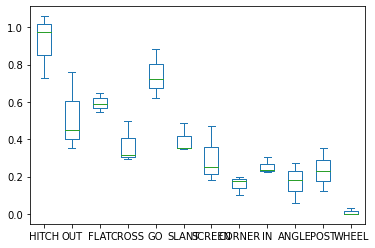

In [122]:
df.groupby(['gameId'])[['HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER',
       'IN', 'ANGLE', 'POST', 'WHEEL']].mean().plot.box()

<AxesSubplot:>

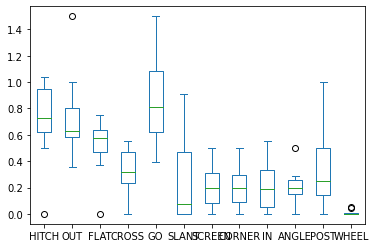

In [118]:
df.groupby('cluster')[['HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER',
       'IN', 'ANGLE', 'POST', 'WHEEL']].mean().plot.box()

In [123]:
cluster0 = df.drop(['gameId', 'playId', 'cluster'], axis=1).loc[(df['cluster'] == 0)]
cluster0.mean().apply(lambda x: '%.5f' % x)

offense_h_presnap         0.11056
offense_h_to_throw        4.88934
offense_h_to_arrived      4.01610
offense_p_presnap         0.40691
offense_p_to_throw        0.50254
offense_p_to_arrived      0.52226
offense_m_presnap         0.23361
offense_m_to_throw        0.32628
offense_m_to_arrived      0.33030
offense_v_presnap         0.02961
offense_v_to_throw        0.67587
offense_v_to_arrived      0.77777
offense_a_presnap        60.55073
offense_a_to_throw      142.89714
offense_a_to_arrived    340.50560
HITCH                     1.04167
OUT                       0.62500
FLAT                      0.62500
CROSS                     0.45833
GO                        0.58333
SLANT                     0.04167
SCREEN                    0.25000
CORNER                    0.16667
IN                        0.37500
ANGLE                     0.16667
POST                      0.25000
WHEEL                     0.04167
num_routes                4.62500
dtype: object

In [124]:
cluster2 = df.drop(['gameId', 'playId', 'cluster'], axis=1).loc[(df['cluster'] == 2)]
cluster2.mean().apply(lambda x: '%.5f' % x)

offense_h_presnap         0.12106
offense_h_to_throw        4.83392
offense_h_to_arrived      3.89285
offense_p_presnap         0.44192
offense_p_to_throw        0.52005
offense_p_to_arrived      0.53159
offense_m_presnap         0.24757
offense_m_to_throw        0.31156
offense_m_to_arrived      0.31986
offense_v_presnap         0.02869
offense_v_to_throw        0.67564
offense_v_to_arrived      0.86626
offense_a_presnap        68.75553
offense_a_to_throw      141.66808
offense_a_to_arrived    278.76568
HITCH                     1.00000
OUT                       0.73684
FLAT                      0.36842
CROSS                     0.31579
GO                        0.84211
SLANT                     0.36842
SCREEN                    0.26316
CORNER                    0.05263
IN                        0.21053
ANGLE                     0.21053
POST                      0.15789
WHEEL                     0.00000
num_routes                4.52632
dtype: object

In [125]:
cluster0.columns

Index(['offense_h_presnap', 'offense_h_to_throw', 'offense_h_to_arrived',
       'offense_p_presnap', 'offense_p_to_throw', 'offense_p_to_arrived',
       'offense_m_presnap', 'offense_m_to_throw', 'offense_m_to_arrived',
       'offense_v_presnap', 'offense_v_to_throw', 'offense_v_to_arrived',
       'offense_a_presnap', 'offense_a_to_throw', 'offense_a_to_arrived',
       'HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER',
       'IN', 'ANGLE', 'POST', 'WHEEL', 'num_routes'],
      dtype='object')

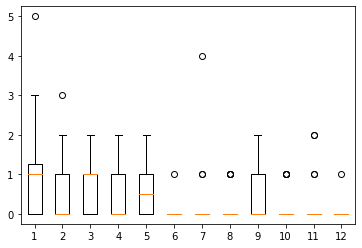

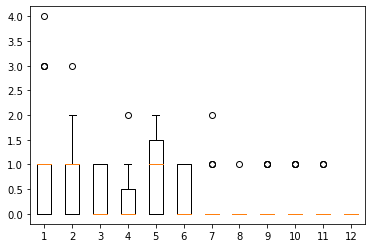

In [126]:
plt.boxplot(cluster0[['HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER',
       'IN', 'ANGLE', 'POST', 'WHEEL']])
plt.show()
plt.boxplot(cluster2[['HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER',
       'IN', 'ANGLE', 'POST', 'WHEEL']])
plt.show()

In [127]:
verticals = df.loc[(df['GO'] == 4)]
sorted(verticals['cluster'].unique().tolist())

[]

In [128]:
flood = df.loc[(df['CORNER'] == 1) & (df['OUT'] == 1) & (df['FLAT'] == 1) & (df['POST'] == 1)]
sorted(flood['cluster'].unique().tolist())

[]

In [129]:
slants = df.loc[(df['SLANT'] >= 2)]
sorted(slants['cluster'].unique().tolist())

[1, 3]

In [130]:
def plot_relationship(df, xcol, ycol, labels):
    fig = plt.figure(figsize=(6, 6))
    grid = plt.GridSpec(4, 4, hspace=0.2, wspace=0.2)
    main_ax = fig.add_subplot(grid[:-1, 1:])
    y_hist = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharey=main_ax)
    x_hist = fig.add_subplot(grid[-1, 1:], yticklabels=[], sharex=main_ax)

    main_ax.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=True,      # ticks along the bottom edge are off
        left=True,
        top=False,         # ticks along the top edge are off
        labelbottom=False,
        labelleft=False) # labels along the bottom edge are off
    x = df[xcol]
    y = df[ycol]
    main_ax.scatter(x, y, c=labels)

    x_hist.hist(x, 40, histtype='stepfilled', orientation='vertical', color='gray')
    x_hist.invert_yaxis()
    x_hist.set_xlabel(xcol)

    y_hist.hist(y, 40, histtype='stepfilled', orientation='horizontal', color='gray')
    y_hist.invert_xaxis()
    y_hist.set_ylabel(ycol)

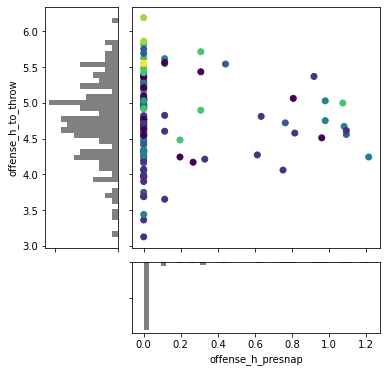

In [131]:
df_columns = df.drop(['gameId', 'playId', 'cluster'], axis=1).columns.tolist()
plot_relationship(df, df_columns[0], df_columns[1], model.labels_)

In [ ]:
df_columns = df.drop(['gameId', 'playId', 'cluster'], axis=1).columns.tolist()
for subset in combinations(df_columns, 2):
    plot_relationship(df, subset[0], subset[1], model.labels_)

(array([70.,  0.,  0., 36.,  0.,  0., 13.,  0.,  0.,  4.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

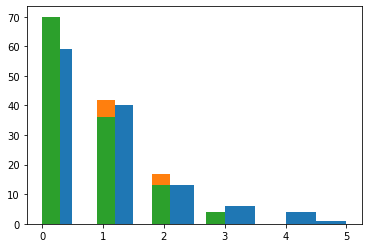

In [132]:
plt.hist(df['HITCH'])
plt.hist(df['GO'])
plt.hist(df['OUT'])

In [ ]:
from mpl_toolkits import mplot3d
%matplotlib notebook

In [ ]:
ax = plt.axes(projection='3d')
x = df_scaled['offense_a_presnap']
y = df_scaled['offense_a_to_throw']
z = df_scaled['offense_a_to_arrived']
ax.scatter3D(x, y, z, c=model.labels_)